### Importing necessary libraries:

In [ ]:
import json
import requests
import numpy as np
import pandas as pd
import plotly.express as px
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.optimizers import Adam
from hyperopt import fmin, tpe, hp
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split

### Reading the training dataset og Google stock price:

In [ ]:
train = pd.read_csv('/content/Google_Stock_Price_Train.csv')

In [ ]:
train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


### Performing data exploration + pre-processing:

In [ ]:
'''Creating new features from the existing features of our dataset by performing feature crossing. 5 new features are created:
1. Daily Change  2. Daily Return  3. High-Low Range  4. Average Price  5. Price Direction'''

# converting 'Close' and 'Open' columns to numeric, handling errors by coercing to NaN
train['Close'] = pd.to_numeric(train['Close'], errors='coerce')
train['Open'] = pd.to_numeric(train['Open'], errors='coerce')


train['Daily Change'] = train['Close'] - train['Open']
train['Daily Return'] = (train['Close'] - train['Open']) / train['Open'] * 100
train['High-Low Range'] = train['High'] - train['Low']
train['Average Price'] = (train['High'] + train['Low']) / 2
train['Price Direction'] = train['Close'].diff()


train

,Date,Open,High,Low,Close,Volume,Daily Change,Daily Return,High-Low Range,Average Price,Price Direction
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500",338.34,104.024596,7.86,328.900,NaN
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400",335.18,101.180306,4.79,331.475,2.86
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300",327.38,99.257193,3.86,328.820,-9.24
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900",319.90,97.429494,5.09,326.225,-8.97
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800",298.72,92.758664,12.83,315.875,-27.48
...,...,...,...,...,...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400",-0.99,-0.125174,5.46,790.010,-1.35
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100",0.87,0.110032,10.20,792.760,1.64
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800",-8.65,-1.089832,11.03,788.715,-6.50
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300",-0.54,-0.068936,7.01,782.425,-2.26


In [ ]:
fig = px.scatter_3d(train, x='Daily Change', y='Daily Return', z='High-Low Range',
                    color='Price Direction', size='Average Price', opacity=0.7,
                    title='3D Scatter Plot of Financial Features')

fig.show()

In [ ]:
fig = px.scatter_3d(train, x='Open', y='Close', z='Daily Return',
                    color='Daily Change', size='Average Price', opacity=0.7,
                    title='3D Scatter Plot of Financial Features')

fig.show()

In [ ]:
fig = px.line(train, x='Date', y='Close', title='Closing Price Over Time')
fig.show()

In [ ]:
fig = px.box(train, x='Price Direction', y='Daily Return', points='all', title='Box Plot of Daily Returns by Price Direction')
fig.show()

In [ ]:
fig = px.area(train, x='Date', y='Daily Return', title='Area Chart of Daily Return Over Time')
fig.show()

In [ ]:
fig = px.violin(train, y='Daily Change', x='Price Direction', box=True, title='Violin Plot of Daily Change by Price Direction')
fig.show()

In [ ]:
training_set=train.iloc[:,1:2].values

In [ ]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
training_set_scaled.shape

(1258, 1)

### Training & evaluating model:

In [ ]:
X_train=[]
y_train=[]
for i in range(60,1258):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# reshaping it to (batche_size(#size of inputs),timesteps,input_dimension)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#### Choosing best hyper-parameters for the model to train on:

In [ ]:
# defining search space for hyperparameters
space = {
    'epochs': hp.choice('epochs', range(10, 101)),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'dropout': hp.uniform('dropout', 0, 0.5),
    'units': hp.choice('units', range(50, 251)),
}

# function to optimize (objective function)
def objective(params):
    # converting integer values
    params['epochs'] = int(params['epochs'])
    params['batch_size'] = int(params['batch_size'])
    params['units'] = int(params['units'])

    # spliting data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # building the LSTM model
    model = Sequential()
    model.add(LSTM(params['units'], input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    # training the model
    model.fit(X_train_split, y_train_split, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

    # predictioning on the validation set
    y_val_pred = model.predict(X_val_split)

    # calculating mean squared error as the objective to minimize
    mse = mean_squared_error(y_val_split, y_val_pred)

    return mse

# performing Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, verbose=1)

# best hyperparameters:
best_epochs = best['epochs']
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_dropout = best['dropout']
best_units = best['units']

print("Best Hyperparameters:")
print("Epochs:", best_epochs)
print("Batch Size:", best_batch_size)
print("Dropout:", best_dropout)
print("Units:", best_units)

1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step

  2%|▏         | 1/50 [05:01<4:06:19, 301.62s/trial, best loss: 0.000572081440457637]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

  4%|▍         | 2/50 [10:35<4:16:17, 320.37s/trial, best loss: 0.00046534976350774785]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

  6%|▌         | 3/50 [11:24<2:33:54, 196.47s/trial, best loss: 0.00046534976350774785]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

  8%|▊         | 4/50 [16:00<2:54:47, 227.99s/trial, best loss: 0.0004277236720441356] 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 10%|█         | 5/50 [17:10<2:08:19, 171.11s/trial, best loss: 0.0004277236720441356]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step

 12%|█▏        | 6/50 [18:47<1:47:02, 145.96s/trial, best loss: 0.0004277236720441356]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 14%|█▍        | 7/50 [19:51<1:25:24, 119.17s/trial, best loss: 0.0004277236720441356]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

 16%|█▌        | 8/50 [23:21<1:43:38, 148.05s/trial, best loss: 0.0004147849443499845]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

 18%|█▊        | 9/50 [35:22<3:43:30, 327.08s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

 20%|██        | 10/50 [37:20<2:54:56, 262.42s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

 22%|██▏       | 11/50 [39:05<2:19:16, 214.26s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step

 24%|██▍       | 12/50 [42:35<2:14:56, 213.06s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

 26%|██▌       | 13/50 [44:00<1:47:25, 174.20s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

 28%|██▊       | 14/50 [44:43<1:20:51, 134.77s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 30%|███       | 15/50 [45:47<1:06:06, 113.34s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

 32%|███▏      | 16/50 [46:27<51:41, 91.21s/trial, best loss: 0.00028032487826815035]   

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 34%|███▍      | 17/50 [49:50<1:08:41, 124.90s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 36%|███▌      | 18/50 [53:55<1:25:47, 160.87s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step

 38%|███▊      | 19/50 [55:06<1:09:16, 134.08s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

 40%|████      | 20/50 [58:19<1:15:50, 151.69s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

 42%|████▏     | 21/50 [1:00:08<1:07:07, 138.88s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step

 44%|████▍     | 22/50 [1:07:42<1:48:58, 233.53s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

 46%|████▌     | 23/50 [1:11:03<1:40:34, 223.51s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

 48%|████▊     | 24/50 [1:14:04<1:31:26, 211.01s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

 50%|█████     | 25/50 [1:24:46<2:21:44, 340.18s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step

 52%|█████▏    | 26/50 [1:34:02<2:41:55, 404.80s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step

 54%|█████▍    | 27/50 [1:39:45<2:28:04, 386.27s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

 56%|█████▌    | 28/50 [1:42:24<1:56:38, 318.13s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

 58%|█████▊    | 29/50 [1:51:26<2:14:56, 385.52s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

 60%|██████    | 30/50 [1:54:12<1:46:30, 319.55s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

 62%|██████▏   | 31/50 [1:55:31<1:18:22, 247.48s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step

 64%|██████▍   | 32/50 [2:00:31<1:18:54, 263.04s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

 66%|██████▌   | 33/50 [2:02:54<1:04:18, 226.98s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

 68%|██████▊   | 34/50 [2:04:28<49:57, 187.35s/trial, best loss: 0.00028032487826815035]  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

 70%|███████   | 35/50 [2:13:10<1:11:56, 287.74s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

 72%|███████▏  | 36/50 [2:13:42<49:12, 210.89s/trial, best loss: 0.00028032487826815035]  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

 74%|███████▍  | 37/50 [2:15:42<39:46, 183.54s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 76%|███████▌  | 38/50 [2:21:40<47:11, 235.94s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

 78%|███████▊  | 39/50 [2:23:41<36:54, 201.34s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step

 80%|████████  | 40/50 [2:27:38<35:22, 212.29s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

 82%|████████▏ | 41/50 [2:29:21<26:54, 179.38s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

 84%|████████▍ | 42/50 [2:31:13<21:13, 159.19s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

 86%|████████▌ | 43/50 [2:32:23<15:26, 132.36s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

 88%|████████▊ | 44/50 [2:37:11<17:53, 178.96s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

 90%|█████████ | 45/50 [2:42:28<18:22, 220.42s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

 92%|█████████▏| 46/50 [2:44:42<12:57, 194.49s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

 94%|█████████▍| 47/50 [2:46:31<08:26, 168.94s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

 96%|█████████▌| 48/50 [2:48:04<04:52, 146.10s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 98%|█████████▊| 49/50 [2:48:52<01:56, 116.79s/trial, best loss: 0.00028032487826815035]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

100%|██████████| 50/50 [2:53:20<00:00, 208.00s/trial, best loss: 0.00028032487826815035]
Best Hyperparameters:
Epochs: 77
Batch Size: 16
Dropout: 0.13172825682206818
Units: 186


In [ ]:
X_train.shape

(1198, 60, 1)

In [ ]:
regressor=Sequential()

In [ ]:
regressor.add(LSTM(units=186,return_sequences=True,input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.13172825682206818))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
regressor.add(LSTM(units=186,return_sequences=True))
regressor.add(Dropout(0.13172825682206818))

In [ ]:
regressor.add(LSTM(units=186,return_sequences=True))
regressor.add(Dropout(0.13172825682206818))

In [ ]:
regressor.add(LSTM(units=186))
regressor.add(Dropout(0.13172825682206818))

In [ ]:
regressor.add(Dense(units=1))

In [ ]:
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
# training the LSTM model
regressor.fit(X_train,y_train,epochs=77,batch_size=16)

Epoch 1/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 417ms/step - loss: 0.0310
Epoch 2/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 402ms/step - loss: 0.0034
Epoch 3/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - loss: 0.0028
Epoch 4/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 435ms/step - loss: 0.0028
Epoch 5/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 407ms/step - loss: 0.0025
Epoch 6/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - loss: 0.0024
Epoch 7/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 402ms/step - loss: 0.0024
Epoch 8/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - loss: 0.0021
Epoch 9/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 436ms/step - loss: 0.0029
Epoch 10/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - loss: 0.0020
Epoch 11/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 420ms/step - loss: 0.0019
Epoch 12/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 407ms/step - loss: 0.0018
Epoch 13/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 422ms/step - loss: 0.0014
Epoch 14/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 411ms/step - loss: 0.0020
Epoch 15/77
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 

In [ ]:
'''Reading the test dataset and performing data pre-processing on it'''

test = pd.read_csv('Google_Stock_Price_Test.csv')

test['Close'] = pd.to_numeric(test['Close'], errors='coerce')
test['Open'] = pd.to_numeric(test['Open'], errors='coerce')

test['Daily Change'] = test['Close'] - test['Open']
test['Daily Return'] = (test['Close'] - test['Open']) / test['Open'] * 100
test['High-Low Range'] = test['High'] - test['Low']
test['Average Price'] = (test['High'] + test['Low']) / 2
test['Price Direction'] = test['Close'].diff()


real_stock_price = test.iloc[:, 1:2].values
total_data=pd.concat([train['Open'],test['Open']], axis=0)

In [ ]:
inputs=total_data[len(train)-len(test)-60:].values
inputs=inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
X_test=[]
for i in range(60,80):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)
X_test.shape
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
predicted_stock_price=regressor.predict(X_test)
predicted_stock_price=sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


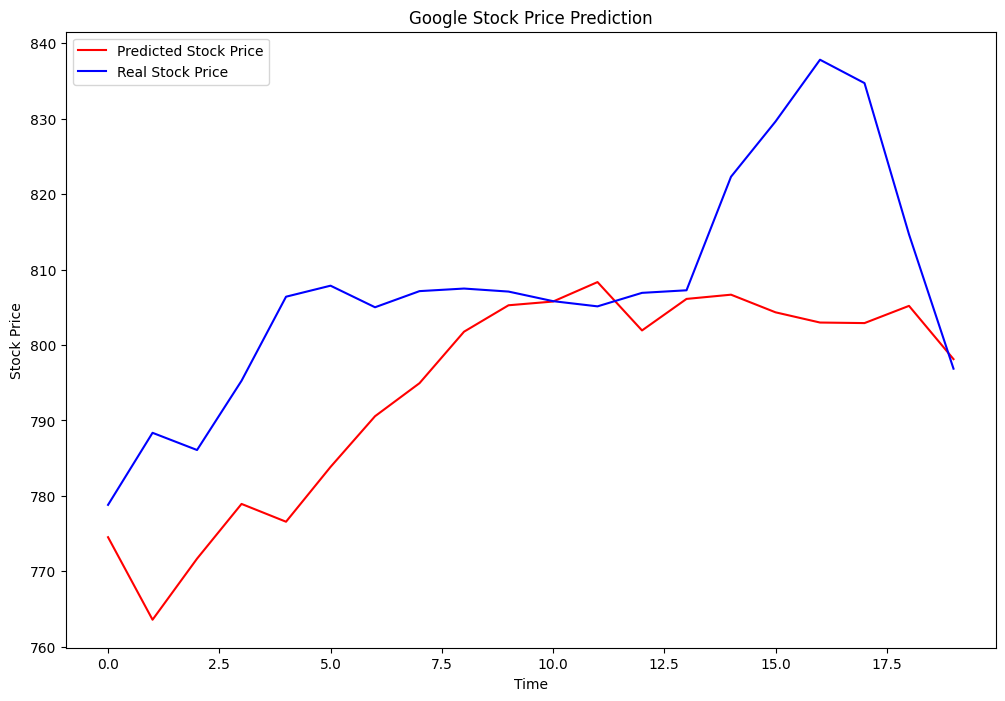

In [ ]:
# visualization of the predictions of model
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(predicted_stock_price,color='red',label='Predicted Stock Price')
plt.plot(real_stock_price,color='blue',label='Real Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# saving the LSTM trained model
regressor.save('stock_price_lstm_model.h5')

In [ ]:
# loading the model back
loaded_model = load_model('stock_price_lstm_model.h5')

In [ ]:
# alpha Vantage API URL
url = "https://www.alphavantage.co/query"

# getting real-time stock data through API
def get_stock_data(symbol, api_key):
    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": "1min",
        "apikey": api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame.from_dict(data['Time Series (1min)'], orient='index')
    df = df.astype(float)
    return df

df_real_time = get_stock_data('GOOGL', 'YOUR_API_KEY')


# preprocessing data as done during training
df_real_time['1. open'] = pd.to_numeric(df_real_time['1. open'], errors='coerce')
df_real_time['4. close'] = pd.to_numeric(df_real_time['4. close'], errors='coerce')

df_real_time['Daily Change'] = df_real_time['4. close'] - df_real_time['1. open']
df_real_time['Daily Return'] = (df_real_time['4. close'] - df_real_time['1. open']) / df_real_time['1. open'] * 100
df_real_time['High-Low Range'] = df_real_time['2. high'] - df_real_time['3. low']
df_real_time['Average Price'] = (df_real_time['2. high'] + df_real_time['3. low']) / 2
df_real_time['Price Direction'] = df_real_time['4. close'].diff()


processed_data = df_real_time

predictions = loaded_model.predict(processed_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [ ]:
print("Data brought in by the API is:")
processed_data = processed_data.reset_index()
processed_data

Data brought in by the API is:


,index,1. open,2. high,3. low,4. close,5. volume,Daily Change,Daily Return,High-Low Range,Average Price,Price Direction
0,2024-01-26 19:59:00,152.04,152.05,152.02,152.02,617.0,-0.02,-0.013154,0.03,152.035,NaN
1,2024-01-26 19:58:00,152.04,152.04,152.04,152.04,6.0,0.00,0.000000,0.00,152.040,0.02
2,2024-01-26 19:57:00,152.03,152.05,152.01,152.05,1328.0,0.02,0.013155,0.04,152.030,0.01
3,2024-01-26 19:56:00,152.01,152.03,152.01,152.03,296.0,0.02,0.013157,0.02,152.020,-0.02
4,2024-01-26 19:55:00,152.05,152.05,152.04,152.04,196.0,-0.01,-0.006577,0.01,152.045,0.01
...,...,...,...,...,...,...,...,...,...,...,...
95,2024-01-26 18:06:00,152.00,152.00,151.98,151.98,665.0,-0.02,-0.013158,0.02,151.990,-0.06
96,2024-01-26 18:05:00,152.02,152.02,152.00,152.00,176.0,-0.02,-0.013156,0.02,152.010,0.02
97,2024-01-26 18:04:00,152.02,152.05,152.02,152.02,300.0,0.00,0.000000,0.03,152.035,0.02
98,2024-01-26 18:02:00,152.02,152.02,152.02,152.02,52.0,0.00,0.000000,0.00,152.020,0.00


In [ ]:
# printing values predicted on live dataset by model
for i in range(100):
    print("Predicted value for", processed_data['index'][i], "is:", predictions[i])

Predicted value for 2024-01-26 19:59:00 is: [nan]
Predicted value for 2024-01-26 19:58:00 is: [1.2499083]
Predicted value for 2024-01-26 19:57:00 is: [1.0850533]
Predicted value for 2024-01-26 19:56:00 is: [1.082293]
Predicted value for 2024-01-26 19:55:00 is: [1.0802623]
Predicted value for 2024-01-26 19:54:00 is: [1.0743879]
Predicted value for 2024-01-26 19:53:00 is: [1.083564]
Predicted value for 2024-01-26 19:52:00 is: [1.0821009]
Predicted value for 2024-01-26 19:51:00 is: [1.0833654]
Predicted value for 2024-01-26 19:50:00 is: [1.251666]
Predicted value for 2024-01-26 19:49:00 is: [1.2106211]
Predicted value for 2024-01-26 19:48:00 is: [1.0750449]
Predicted value for 2024-01-26 19:47:00 is: [1.2526977]
Predicted value for 2024-01-26 19:46:00 is: [1.2532067]
Predicted value for 2024-01-26 19:45:00 is: [1.2564411]
Predicted value for 2024-01-26 19:44:00 is: [1.0817105]
Predicted value for 2024-01-26 19:42:00 is: [1.116599]
Predicted value for 2024-01-26 19:41:00 is: [1.0787679]
Pr